## Running Hijacking Experiments

**NOTE**: If this is your first time using this repository, we recommend that you begin with `run-lanefollow-experiments.ipynb` before going through this notebook.


In this notebook, we will step through the process of searching for attacks for a **particular intersection scene**. By intersection, we mean that the imitation learning network is trying to *execute a particular turn at an intersection*. Our goal is to find attacks that cause the self-driving agent to take an unintended turn (e.g. take a left turn instead of taking a right turn). The three scenarios (tasks) available are:
1. Right turn at an intersection (intersection-right)
2. Left turn at an intersection (intersection-left)
3. Drive straight through an intersection (intersection-straight)

For each of the above scenarios, we can attack two different scenes which correspond to different locations on CARLA's Town01 map. Therefore the six possible experiments to run are:

1. intersection-right, scene 1 -> intersection-left, scene 2
2. intersection-left, scene 2 -> intersection-right, scene 1
3. intersection-straight, scene 1 -> intersection-left, scene 1
4. intersection-left, scene 1 -> intersection-straight, scene 1
5. intersection-right, scene 2 -> intersection-straight, scene 2
6. intersection-straight, scene 2 -> intersection-right, scene 1

## PREREQUISITE
Before running the code in this notebook, please make sure you have started the **adversary server** and **CARLA simulator** using the scripts we have provided in this Github repository.

In your terminal, run
```bash
sh run_adv_server.sh
```
If you are running the provided dockerized version of CARLA, run:
```bash
sh run_carla_docker.sh
```
However, if you are working with CARLA natively, run
```bash
./CarlaUE4.sh -windowed -ResX=800 -ResY=600
```

### Step 1: Import Dependencies
The `carla_env` library is a wrapper we have created on an [OpenAI Gym](https://gym.openai.com/) environment. You can learn how to create your own gym environemnt [here](https://github.com/openai/gym/blob/master/docs/creating-environments.md). [`bayes_opt`](https://github.com/fmfn/BayesianOptimization) allows us to use Bayesian Optimization as the search policy for generating new adversaries. 

In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from carla_env import CarlaEnv
from matplotlib import gridspec
import matplotlib.pyplot as plt
from utils import plot_trajectories
from bayes_opt import UtilityFunction
from bayes_opt import BayesianOptimization

%matplotlib inline
warnings.filterwarnings('ignore')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Step 2: Set up simulation parameters
Here, we will set up the tasks, towns, scenes, gpus, and ports available. Make sure to choose the town and port that correspond to the instance of CARLA. By default, both native CARLA and the dockerized version of CARLA set the port to `2000` and the town name to `Town01_nemesisA`.

In [2]:
tasks  = {0 : "intersection-right",
         1 : "intersection-left",
         2 : "intersection-straight"}
towns  = ['Town01_nemesisA']
scenes = [1, 2]
GPUS   = [0,1,2,3,4,5,6,7]
ports  = [2000]

### Step 3: Choose simulatior parameters
Now, let's choose the parameters for our experiment. In this case, we will run the `intersection-right` scenario on scene `0`. Note the port and town name match those instantiated in CARLA.

In [3]:
target_task    = tasks[0] # intersection-right
baseline_task  = tasks[1] # intersection-left
target_scene   = scenes[0] # scene 1
baseline_scene = scenes[1] # scene 2 (experiment #1 as listed above)
curr_town      = towns[0]
curr_scene     = scenes[0]
curr_gpu       = GPUS[0]
curr_port      = ports[0]

In [4]:
directory_to_save = './_benchmarks_results/{}'.format(curr_town)

The following two cells check if the directory in which results will be saved exists. If you have already run this notebook and would like to save the data, please make sure to move the contents into a new directory.

In [5]:
if os.path.exists(directory_to_save):
    print("WARNING: A directory called {} already exists.".format(directory_to_save))
    print("Please make sure to move the contents as running this notebook will overwrite the contents of this directory.")

Please make sure to move the contents as running this notebook will overwrite the contents of this directory.


This command will delete all content in the directory.

In [6]:
os.system("rm -rf {}".format(directory_to_save))

0

### Step 4: Load the Imitation Learning Agent and Run Target Scenario
The following call to the `CarlaEnv` class will load the imitation learning network and execute the simulation in which *no adversary has been placed on the road* and takes the target path. By target path, we mean the hijacking path we would like the self-driving agent to take. The `save_images` flag can be set to true which will save the images for each simulation run in the same directory as mentioned earlier.

In [7]:
now = time.time()
os.system("mkdir -p _benchmarks_results")
env = CarlaEnv(task=target_task, town=curr_town, scene=target_scene, 
               port=curr_port, save_images=False, gpu_num=curr_gpu)
print("\n{} seconds to load the imitation learning network and perform one simulation run".format(time.time() - now))

Starting CARLA gym environment
Ensure that CARLA is running on port 2000
Loading Imitation Learning model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Network/conv_block0/relu1:0", shape=(?, 42, 98, 32), dtype=float32)
Tensor("Network/conv_block1/relu2:0", shape=(?, 40, 96, 32), dtype=float32)
Tensor("Network/conv_block2/relu3:0", shape=(?, 19, 47, 64), dtype=float32)
Tensor("Network/conv_block3/relu4:0", shape=(?, 17, 45, 64), dtype=float32)
Tensor("Network/conv_block4/relu5:0", shape=(?, 8, 22, 128), dtype=float32)
Tensor("Network/conv_block5/relu6:0", shape=(?, 6, 20, 128), dtype=float32)
Tensor("Network/conv_block6/relu7:0", shape=(?, 4, 18, 256), dtype=float32)
Tensor("Network/conv_block7/relu8:0", shape=(?, 2, 16, 256), dtype=float32)
Tensor("Network/reshape:0", shape=(?, 8192), dtype=float32)
Tensor("Network/fc1/relu9:0", shape=(?,

### Step 5: Sanity Check and Plot Target Case
Now that the baseline case has run, we can plot the location of the agent over the simulation run and examine the data from that run. A full list of available functions from the `env` object can be found in `carla_env.py`. We will be using the `plot_trajectories` function from the `utils.py`.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

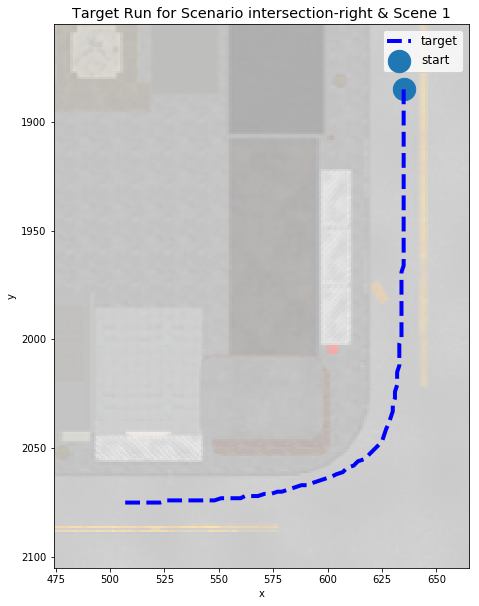

In [8]:
targetSteer       = env.baseline_steer                   # get the steering angles for the target run
targetX, targetY  = env.positions                        # get x,y position of the car
MAX_LEN           = int(len(env.baseline_steer)*.8)      # set maximum number of frames to 80 percent of target scenario 
  
targetSteer      = targetSteer[:MAX_LEN]                  # subset steering angles to maximum number of allowed frames

title = "Target Run for Scenario {} & Scene {}".format(target_task, target_scene)
trajectories_dict = {'target' : {'x' : targetX, 'y' : targetY},
                     'start' :  {'x' : targetX[0:1], 'y' : targetY[0:1]}}
plot_trajectories(trajectories_dict, title)

Text(0, 0.5, 'Steering Angle (radians)')

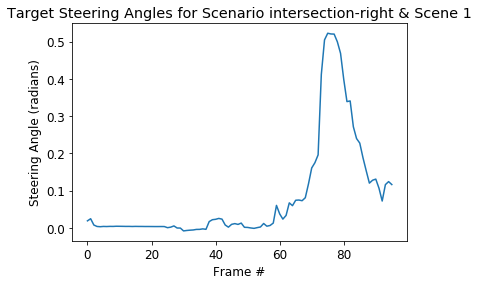

In [9]:
plt.plot(targetSteer)
plt.title("Target Steering Angles for Scenario {} & Scene {}".format(target_task, curr_scene))
plt.xlabel("Frame #")
plt.ylabel("Steering Angle (radians)")

### Step 6: Run Baseline Scenario
Now, we will change the task to the baseline path. By baseline path, we mean the path that the self-driving agent *shoudl take* given that there are no attacks. In order to change the task to the baseline path, we must import the underlying python functions (`run_driving_benchmark` and `AdversarySuite`), and run those within this environment.

In [10]:
from carla.driving_benchmark import run_driving_benchmark
from carla.driving_benchmark.experiment_suites import AdversarySuite
env.task  = baseline_task
env.scene = baseline_scene
env.experiment_name = 'baseline'

# reset experiment suite with base task + scene
env.experiment_suite = AdversarySuite(env.town, env.task, env.weather, env.iterations, env.scene)

# run the baseline simulation
run_driving_benchmark(env.agent, env.experiment_suite, log_name=env.experiment_name,
                    city_name=env.town, port=env.port, save_images=False)

### Step 7: Sanity Check and Plot both Runs
Now, we will plot both the target and baseline path.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

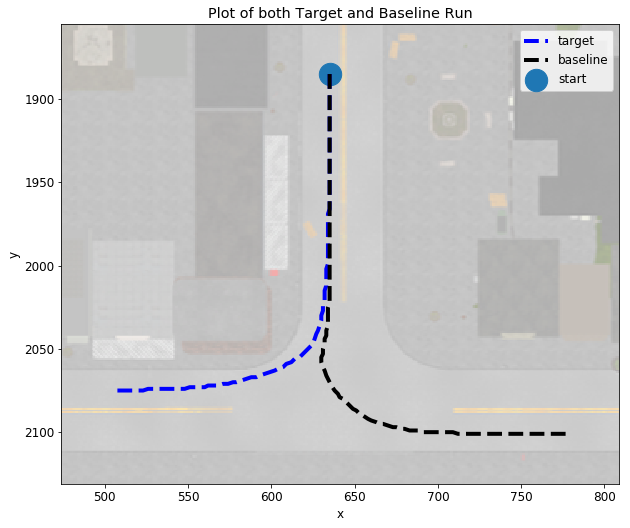

In [11]:
baseSteer      = env.get_steer()
baseX, baseY   = env.get_xy()
MAX_LEN_B      = int(len(baseSteer)*.8)
baseSteer      = baseSteer[:MAX_LEN_B]

title = "Plot of both Target and Baseline Run"
trajectories_dict = {'target'   : {'x' : targetX, 'y' : targetY},
                     'baseline' : {'x' : baseX, 'y' : baseY},
                     'start'    : {'x' : baseX[0:1], 'y' : baseY[0:1]}}

plot_trajectories(trajectories_dict, title)

### Step 6: Set up Bayesian Optimizer
The main objective of any optimization problem is to find $ argmax \text{ } f(x) $. Here $x$ defines the parameters for our attacks, which in our case are two black lines painted on the road. We would like to find an adversary that maximizes the chance of causing an infraction in the form of a collision, opposite lane infraction, or offroad infraction. 

The bayesian optimization package we use requires us to define the function $f(x)$, which encapsulates our belief about the *successfulness* of an attack. The target function below defines $f(x)$. Notice that the target function actually runs the simulation *with that attack placed on the road* and collects these measurements back into the python environment. Finally, `target` returns the value of $f(x)$. In this example, our objective function is

$$
\begin{align}
||\vec{\Theta}_{\delta} - \vec{\Theta}_{\text{target}}{||}_1 
\end{align}
$$

where $\vec{\Theta}_{\delta}$ are the steering angles collected over the simulation *with an adversary placed on the road* and $ \vec{\Theta}_{\text{target}}$ are the steering angles collected in the target run above *with no adversary placed on the road*. $||(.)||_1$ denotes the L1 norm. *Note that we would like to minimize this function* as we would like the self-driving agent to take the target route. Essentially, the above equation finds the absolute difference in the steering angles per frame and sums across all frames. By minimizing this objective function, we are minimizing a path deviation from the target run that is proxied through the steering angles.

[Bayesian Optimization works](https://arxiv.org/pdf/1807.02811.pdf) by choosing the parameters of the target function based on information from the previous simulation runs. 

In [13]:
def target(pos1, rot1, pos2=0, rot2=0, width=10, length=200, colorR=0, colorG=0, colorB=0):
    # specify our attack (in this case double black lines) as a dictionary to pass to the CarlaEnv object.
    dict_params = {
        # the first line
        0:{
            'pos': int(pos1),
            'rot': rot1,
            'width': int(width),
            'length': int(length),
            'color': (int(colorB), int(colorG), int(colorR), 255)
        },
        # the second line
        1:{
            'pos': int(pos2),
            'rot': rot2,
            'width': int(width),
            'length': int(length),
            'color': (0, 0, 0, 255)
        }
    }

    # run the simulation with that attack and fetch the data from that run
    metrics = env.step(dict_params)
    
    # calculate the objective function we are trying to maximize
    attackSteer    = metrics['steer'][:MAX_LEN]
    
    # if attackSteer vector is shorter than baseSteer, extend attackSteer with baseSteer.
    # This takes care of difference in vector lengths without changing the L1 value 
    # as extended part of attackSteer will have zero difference with same part of baseSteer
    if len(attackSteer) < len(targetSteer):
        attackSteer = np.append(attackSteer, targetSteer[len(attackSteer):])

    # return objective function value for this particular run
    return -1 * np.sum(np.abs(attackSteer - targetSteer))

### Step 7: Run the Bayesian Optimization Search Policy
Now, we will let Bayesian Optimization choose the parameters of our attacks and calculate the objective funciton for each simulation run. We will set a budget for the maximum number of iterations we will let the optimizer run.

In [14]:
# define the bounds for our attack parameters. 
# in our case, the position of both lines can start between pixel 0 and pixel 190.
# the rotation of each line can over pi radians.
controls = {'pos1': (0, 190), 
            'rot1': (0, 179),
            'pos2': (0, 200), 
            'rot2': (0, 179)}

random_points        = 5  # these runs are used for hyperparameter tuning of the underlying Gaussian Process for BayesOpt
search_points        = 5  # number of points to search using bayesian optimization
acquisition_function = 'ei' # or 'ucb' specifies the acquisition function of the bayesian optimizer.

# instantiate the bayesian optimizer
optimizer = BayesianOptimization(target, controls, random_state=42)
optimizer.maximize(init_points=random_points, n_iter=search_points, acq=acquisition_function)

|   iter    |  target   |   pos1    |   pos2    |   rot1    |   rot2    |
-------------------------------------------------------------------------
|  1        | -2.595    |  71.16    |  190.1    |  131.0    |  107.2    |
|  2        | -13.77    |  29.64    |  31.2     |  10.4     |  155.0    |
|  3        | -14.13    |  114.2    |  141.6    |  3.685    |  173.6    |
|  4        | -13.58    |  158.2    |  42.47    |  32.55    |  32.83    |
|  5        | -14.74    |  57.81    |  105.0    |  77.32    |  52.13    |
|  6        | -2.399    |  73.11    |  195.1    |  135.0    |  103.1    |
|  7        | -2.643    |  74.53    |  199.0    |  134.9    |  111.5    |
|  8        | -2.482    |  74.05    |  192.5    |  145.3    |  104.9    |
|  9        | -2.4      |  66.05    |  197.9    |  139.6    |  97.97    |
|  10       | -2.578    |  75.96    |  198.3    |  132.8    |  96.87    |


### Step 8: Analysis
The output of `optimizer.maximize` shows the value of the objective function (the column target) with the corresponding parameters of the attack. The output of each run is stored in the directory `_benchmarks_results/Town01_nemesisA`. Refer to the `plot_experiments.ipynb` notebook to see how to interact with this data.